Clean model maker


In [1]:
#imports
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import tensorflow.keras.metrics # import Precision, Recall,Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import classification_report

# Set parameters

In [2]:
#for data splits
batch_size = 16 #None = 1 #16 #32
img_height = 224
img_width = 224
seed_train_validation = 69 # Must be same for train_ds and val_ds
shuffle_value = True
#validation_split = 0.2 irrelevant


In [3]:
new_way = True
label_mode = "int" 

def load_data_new_way():
    #path_to_dataset = os.path.join("..", "test_data", "3_test_from_bucket2")
    #path_to_dataset = os.path.join("..","..","data","food")
    
    path_to_dataset = os.path.join("..", "..", "test_data", "2_whole_data_some_dups")
    
    path_to_dataset_train = os.path.join(path_to_dataset, "train")
    path_to_dataset_test = os.path.join(path_to_dataset,  "test")
    path_to_dataset_val = os.path.join(path_to_dataset,   "val")
    
    X_train = image_dataset_from_directory(
        path_to_dataset_train,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_val = image_dataset_from_directory(
        path_to_dataset_val,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_test = image_dataset_from_directory(
        path_to_dataset_test,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False
        )
    return X_train,X_val,X_test
X_train, X_val, X_test = load_data_new_way()

#print sample label

Found 23076 files belonging to 33 classes.
Found 7875 files belonging to 33 classes.
Found 3914 files belonging to 33 classes.


In [4]:
path_to_dataset = os.path.join("..", "data")#, "2_test_from_bucket")
#new_way = False
def load_data_old_way():
    path_to_dataset = os.path.join("..", "data")#, "2_test_from_bucket")
    val_split = 0.3
    
    X_train = image_dataset_from_directory(
        path_to_dataset,
        validation_split=val_split,
        subset="training",
        label_mode="int",
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_val_ds = image_dataset_from_directory(
        path_to_dataset,
        validation_split=val_split,
        subset="validation",
        label_mode="int",
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    val_batches = tf.data.experimental.cardinality(X_val_ds)
    #print(val_batches//2)    # tf.Tensor(2131, shape=(), dtype=int64)

    X_val  = X_val_ds.take( val_batches // 2 ) #15%a
    X_test = X_val_ds.skip( val_batches // 2 ) #15%
    #DON'T SHUFFLE TEST DATA
    X_test.shuffle = False
    
    return X_train,X_val,X_test

if new_way == False:
    X_train, X_val, X_test = load_data_old_way()

In [5]:
#(images, labels) = X_test


In [6]:
train_batches = tf.data.experimental.cardinality(X_train)
test_batches = tf.data.experimental.cardinality(X_test)
val_batches = tf.data.experimental.cardinality(X_val)

train_batches.numpy() , test_batches.numpy() ,val_batches.numpy()

(1443, 245, 493)

In [7]:
X_val


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Prep for model

test label: [32  3  1 16 18 31 18  5 32 21  9 15  2 21 18 15]
first test label: 32


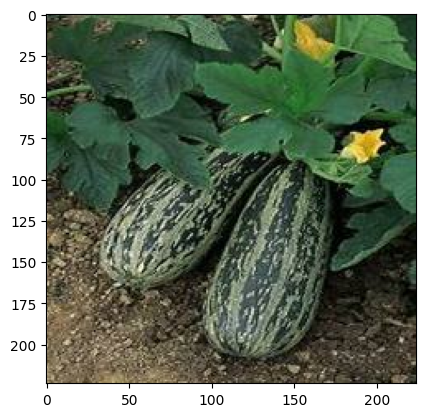

In [8]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None

for image, label in X_train:#.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
    
#if you want to see an image
print("test label:", test_label)
print("first test label:", test_label[0])
plt.imshow(test_image[0]/255)


In [9]:
in_shape = test_image[0].shape
in_shape

num_classes = len(X_train.class_names)
print("num_classes: ", num_classes)
print("in_shape: "   , in_shape)

num_classes:  33
in_shape:  (224, 224, 3)


# Create model

In [63]:
#declare model
def instantiate_model():
    model = models.Sequential()

    #normalise the inputs
    model.add(layers.Rescaling(1./255))

    #first convolutional layer - big kernels, few filters
    model.add(layers.Conv2D(16, kernel_size=(5,5), padding="same", activation="relu", input_shape=in_shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    
    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #third conv layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Flatten
    model.add(layers.Flatten())

    #Dense layers - do we regularise the kernels?!
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    # model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(32, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) )
    model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) ) 

    #Last layer, convert for appropriate model output
    model.add(layers.Dense(num_classes, activation="softmax"))
    #model.add(layers.Dense(num_classes, activation="softmax"))
    
    return model

model = instantiate_model()


In [65]:
#compile model
from tensorflow.keras import metrics as mets
def compile_model(model):
    loss = "sparse_categorical_crossentropy"
    learning_rate=0.001 #default 0.001
    
    # loss = "categorical_crossentropy"
    #optimizer = "adam"
    optimizer = tensorflow.keras.optimizers.Adam(
        learning_rate=learning_rate
    )
    
    #metrics = ["accuracy"]
    #metrics = [Precision(), Recall(), Accuracy()]
    #metrics = [Precision()]
    
    metrics = [mets.SparseCategoricalAccuracy(), "accuracy"] #??
    # metrics = [mets.CategoricalAccuracy()]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
model = compile_model(model)
model.__dict__;

In [43]:
def fit_model(model):
    #prep for early stopping
    patience = 20
    epochs = 100
    
    es = EarlyStopping(patience=patience, restore_best_weights=True)

    #fit
    history = model.fit(
            X_train, 
            validation_data=X_val, 
            #epochs=epochs,
            epochs=5,
            batch_size=16,
            callbacks=[es], 
            verbose=1
        )
    return history, model

history, model = fit_model(model)

#if below error, RESTART KERNEL(s)!:
# 2023-03-08 16:05:03.024852: E tensorflow/stream_executor/cuda/cuda_dnn.cc:373] 
# Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR

Epoch 1/5
1443/1443 [==============================] - 36s 24ms/step - loss: 3.2078 - sparse_categorical_accuracy: 0.0676 - accuracy: 0.0676 - val_loss: 2.8809 - val_sparse_categorical_accuracy: 0.1125 - val_accuracy: 0.1125
Epoch 2/5
1443/1443 [==============================] - 35s 24ms/step - loss: 2.7736 - sparse_categorical_accuracy: 0.1508 - accuracy: 0.1508 - val_loss: 2.4224 - val_sparse_categorical_accuracy: 0.2160 - val_accuracy: 0.2160
Epoch 3/5
1443/1443 [==============================] - 34s 24ms/step - loss: 2.5117 - sparse_categorical_accuracy: 0.2076 - accuracy: 0.2076 - val_loss: 2.2229 - val_sparse_categorical_accuracy: 0.2833 - val_accuracy: 0.2833
Epoch 4/5
1443/1443 [==============================] - 35s 24ms/step - loss: 2.3524 - sparse_categorical_accuracy: 0.2550 - accuracy: 0.2550 - val_loss: 2.1045 - val_sparse_categorical_accuracy: 0.3261 - val_accuracy: 0.3261
Epoch 5/5
1443/1443 [==============================] - 34s 24ms/step - loss: 2.2113 - sparse_categor

## Saving model

In [ ]:
#model_name = "100_epochs_on_21_classes"
model_name = None


In [14]:
#model_name = "simple_try_on_unaugmented_33_classes"
def save_model(model, model_name):
    path_to_models = os.path.join("..","..","models")
    os.makedirs(path_to_models, exist_ok=True) #True means don't create new dir if already exists #os.makedirs(path, exist_ok=True)

    if not model_name:
        print("please give the model a name! #goodpractice")
        print("model NOT saved")
        return None
    
    model_path = os.path.join(path_to_models, model_name)
    
    model.save(model_path)
    
    return f"model saved in {path_to_models} as {model_name}"

In [15]:
save_model(model, model_name)

INFO:tensorflow:Assets written to: ../../models/simple_try_on_unaugmented_33_classes/assets


'model saved in ../../models as simple_try_on_unaugmented_33_classes'

## Getting y out

In [21]:
#pull target out of tensorflow.dataset
#can do train test or val (seems that test is batches of 1?)
def get_y_from_X(X, batched=True):
    
    y_batched = []
    y = []
    
    for batch_image, batch_label in X:
        
        if batched:
            y_batched.append(batch_label.numpy())
        else:
            for image,label in zip(batch_image, batch_label):
                y.append(label.numpy())
     
    if batched:
        print("len y_batched", len(y_batched) )
        return y_batched
    else:
        print("len y", len(y))
        return y

In [22]:
count=0

for thing, label in X_test.take(1):
    if count == 0:
        print(label)
    count += 1


tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [23]:
def get_y_test(X_test_in):
    y_test = get_y_from_X(X_test_in, batched=False)
    return y_test
    
def get_y_pred(X_test_in):
    #gets array with probabilities
    # if model_name != None:
    #     print(f"getting predictions from {model_name}")
    # else:
    #     print(f"getting predictions from unnamed (probably not saved) 'model'")
        
    y_pred_0 = model.predict(X_test, verbose=1)
    y_pred = []
    
    for pred in y_pred_0:
        y_pred.append(pred.argmax())
        
    return y_pred


In [24]:
#get y_pred and y_true out of X_test, thanks to above funcs
y_pred = get_y_pred(X_test)
y_test = get_y_test(X_test)
y_pred;

245/245 [==============================] - 2s 9ms/step
len y 3914


In [25]:
path_to_dataset = os.path.join("..", "..", "test_data", "2_whole_data_some_dups")
    
if new_way:
    path_to_dataset_train = os.path.join(path_to_dataset, "train")
    path_to_dataset_test = os.path.join(path_to_dataset,  "test")
    path_to_dataset_val = os.path.join(path_to_dataset,   "validation")

In [26]:
def get_target_dict():
    if new_way:
        classes = os.listdir(path_to_dataset_train)
    else:
        classes = os.listdir(path_to_dataset)
    classes.sort()
    
    target_dict_out = {}
    for index, veg in enumerate(classes):
        target_dict_out[index] = veg
    
    return target_dict_out
target_dict = get_target_dict()
target_dict

{0: 'apple',
 1: 'asparagus',
 2: 'avocado',
 3: 'banana',
 4: 'beetroot',
 5: 'blueberry',
 6: 'broccoli',
 7: 'cabbage',
 8: 'carrot',
 9: 'cauliflower',
 10: 'celery',
 11: 'chicken',
 12: 'corn',
 13: 'cranberry',
 14: 'cucumber',
 15: 'eggplant',
 16: 'garlic',
 17: 'ginger',
 18: 'grape',
 19: 'kiwi',
 20: 'leek',
 21: 'lemon',
 22: 'lettuce',
 23: 'lime',
 24: 'mushroom',
 25: 'onion',
 26: 'orange',
 27: 'pineapple',
 28: 'potato',
 29: 'pumpkin',
 30: 'spinach',
 31: 'tomato',
 32: 'zucchini'}

In [28]:
#can be useful to have them just as list
if new_way:
    classes_list = os.listdir(path_to_dataset_train)
else:
    classes_list = os.listdir(path_to_dataset)
classes_list.sort()
classes_list
classes_code = [i for i in range(len(classes_list))]
classes_code;

In [29]:
import pandas as pd
df = pd.DataFrame({"y_pred" : y_pred ,"y_test" : y_test})
df

,y_pred,y_test
0,0,0
1,0,0
2,18,0
3,0,0
4,0,0
...,...,...
3909,32,32
3910,32,32
3911,32,32
3912,23,32


## Looking at results

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes_list))

              precision    recall  f1-score   support

       apple       0.39      0.41      0.40       181
   asparagus       0.82      0.57      0.67       225
     avocado       0.50      0.32      0.39       176
      banana       0.47      0.40      0.43       175
    beetroot       0.00      0.00      0.00        10
   blueberry       0.60      0.72      0.65       151
    broccoli       0.92      0.83      0.87       200
     cabbage       0.49      0.90      0.63       200
      carrot       0.96      0.97      0.97       200
 cauliflower       0.91      0.45      0.60       200
      celery       0.00      0.00      0.00         7
     chicken       0.67      0.08      0.14        26
        corn       0.00      0.00      0.00        10
   cranberry       0.75      0.79      0.77       156
    cucumber       0.63      0.92      0.75       200
    eggplant       0.82      0.78      0.80       153
      garlic       0.67      0.20      0.31        10
      ginger       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


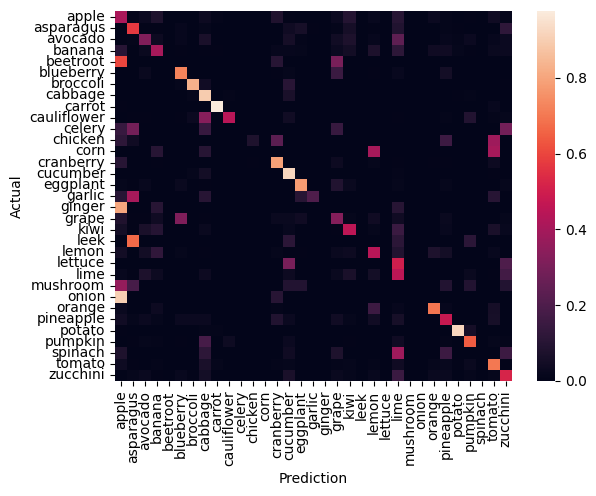

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true') #true as in truth
s = sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)
s.set(ylabel="Actual", xlabel="Prediction");

## Learning Curve

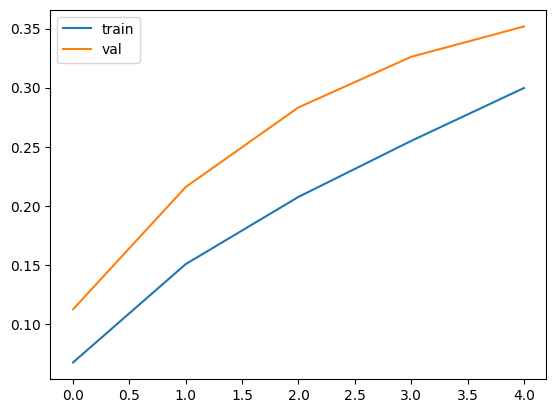

In [61]:
history.history;
train_accuracy = history.history["sparse_categorical_accuracy"]
val_accuracy = history.history["val_sparse_categorical_accuracy"]

plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy,label="val")
plt.legend()

# EXPERIMENTATION

will move the good stuff above

#idea 
create random prediction func that we can run and inspect incorrect predictions?

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
out = classification_report(y_test, y_pred, output_dict=True)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix
#out

In [ ]:
num_test = tf.data.experimental.cardinality(X_test)
num_test.numpy()

In [ ]:
y_pred = model.predict(X_test, verbose=1)

In [ ]:
num_test = tf.data.experimental.cardinality(X_test.take(1))
num_test.numpy()

In [ ]:
out = classification_report(y_true, y_pred, output_dict=True)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true')

# cm_df = pd.DataFrame(cm,
#                      index = target_dict.values(), 
#                      columns = target_dict.values())

sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes_list))

In [ ]:
classes_list

In [ ]:
out

In [ ]:
#out

pred_comparison_limit = 10
count=0
for y_t, y_p in zip(y_true , y_pred):
    print(f"true: {y_t}  pred:{y_p}")
    count+=1
    
    if count > pred_comparison_limit:
        break

In [ ]:
#get labels from folders, must be done in 2 lines...
classes = os.listdir(path_to_dataset_train)
classes.sort()

In [ ]:
target_dict = {}
for index,classs in enumerate(classes):
    target_dict[index] = classs
    
print(target_dict.values())

In [ ]:
path_to_dataset

In [ ]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None
for image, label in X_test.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
#if you want to see an image
print(test_label[0])
plt.imshow(test_image[0]/255)

In [ ]:
model.evaluate(X_test, return_dict=True)

{'loss': [3.207814931869507,
  2.7735602855682373,
  2.511685609817505,
  2.352437973022461,
  2.211341142654419],
 'sparse_categorical_accuracy': [0.06760270148515701,
  0.15080603957176208,
  0.20761831104755402,
  0.2549835443496704,
  0.2997053265571594],
 'accuracy': [0.06760270148515701,
  0.15080603957176208,
  0.20761831104755402,
  0.2549835443496704,
  0.2997053265571594],
 'val_loss': [2.880866527557373,
  2.422410249710083,
  2.2229113578796387,
  2.104482889175415,
  1.9930988550186157],
 'val_sparse_categorical_accuracy': [0.11250793933868408,
  0.2160000056028366,
  0.28330159187316895,
  0.32609522342681885,
  0.3517460227012634],
 'val_accuracy': [0.11250793933868408,
  0.2160000056028366,
  0.28330159187316895,
  0.32609522342681885,
  0.3517460227012634]}

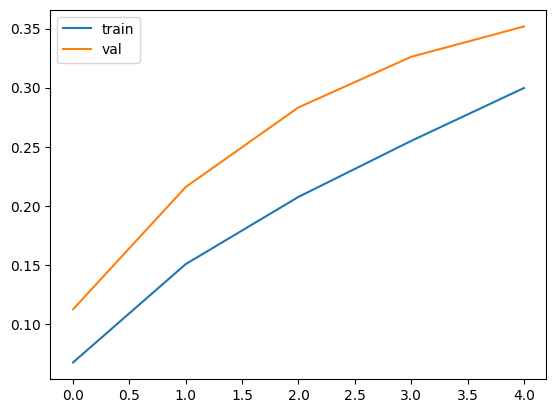

In [60]:
history.history;
train_accuracy = history.history["sparse_categorical_accuracy"]
val_accuracy = history.history["val_sparse_categorical_accuracy"]

plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy,label="val")
plt.legend()